Design And Evaluating Medical AI Models|A case study of chest X-Ray

In [1]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

LEARNING_RATE = 0.0001
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


2023-11-24 22:15:06.083543: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 22:15:06.365816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 22:15:06.365872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 22:15:06.423362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 22:15:06.545293: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 22:15:06.547850: I tensorflow/core/platform/cpu_feature_guard.cc:1

Preparing the data

In [2]:
finding = "pneumothorax"
finding = finding.capitalize()

In [3]:
df = pd.read_csv("files/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [4]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found")
  assert (n > 0)

In [5]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

78 19


In [6]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])


In [7]:
rootdir = "files/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [8]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 196 images to positive and negative folders.


In [9]:
# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

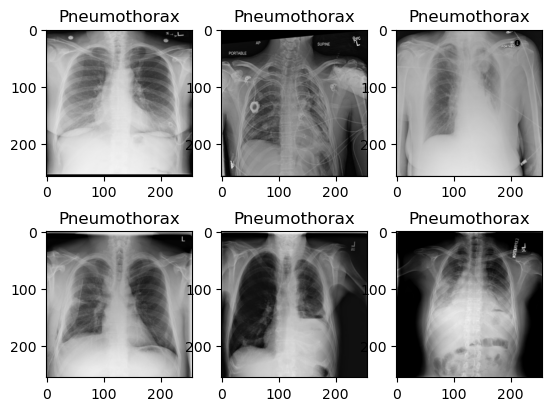

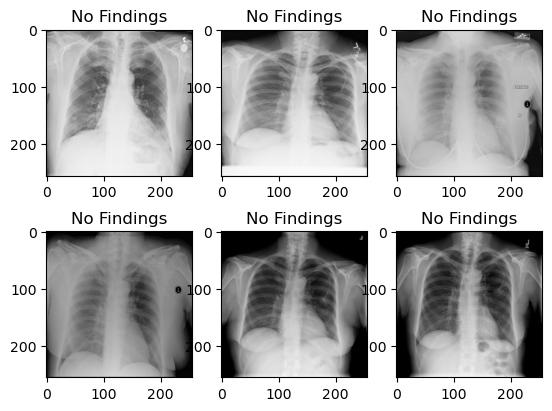

In [10]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

Model Training

In [11]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation(introduces non-linearity to the model. )
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) # Add a final sigmoid layer for classification(It squashes the output values between 0 and 1, representing the probability of the input belonging to the positive class.)

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
#Binary cross-entropy is a measure of how well the predicted probabilities match the actual outcomes
#Adam is an optimization algorithm used to minimize the error (loss) of a neural network during training. 
print("Done compiling the model!")

2023-11-24 22:15:30.712833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-24 22:15:30.713209: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-24 22:15:33.424209: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.
2023-11-24 22:15:33.688822: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10

Done compiling the model!


In [12]:
# Define our example directories and files
base_dir = rootdir = "files/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [13]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to be between 0 and 1
    rotation_range=40,  # Rotate images randomly up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by a fraction of total width
    height_shift_range=0.2,  # Shift images vertically by a fraction of total height
    shear_range=0.2,  # Shear intensity (shear angle in radians)
    zoom_range=0.2,  # Randomly zoom into images
    horizontal_flip=False)  # Randomly flip images horizontally (disabled in this case)


# Note that the test data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("Done funneling data!")

Found 156 images belonging to 2 classes.


Found 40 images belonging to 2 classes.
Done funneling data!


Running the model

In [15]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=20,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

Epoch 1/20


2023-11-24 23:04:57.483346: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.
2023-11-24 23:04:57.716150: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 616562688 exceeds 10% of free system memory.


156/156 - 582s - loss: 11.0125 - acc: 0.5577 - val_loss: 1.1214 - val_acc: 0.8000 - 582s/epoch - 4s/step
Epoch 2/20
156/156 - 480s - loss: 4.8331 - acc: 0.6538 - val_loss: 5.3071 - val_acc: 0.5750 - 480s/epoch - 3s/step
Epoch 3/20
156/156 - 380s - loss: 2.4967 - acc: 0.7372 - val_loss: 0.7163 - val_acc: 0.8000 - 380s/epoch - 2s/step
Epoch 4/20
156/156 - 381s - loss: 1.1427 - acc: 0.6731 - val_loss: 0.5011 - val_acc: 0.7250 - 381s/epoch - 2s/step
Epoch 5/20
156/156 - 382s - loss: 0.6644 - acc: 0.7436 - val_loss: 0.8205 - val_acc: 0.6750 - 382s/epoch - 2s/step
Epoch 6/20
156/156 - 381s - loss: 0.5063 - acc: 0.7885 - val_loss: 0.3978 - val_acc: 0.8500 - 381s/epoch - 2s/step
Epoch 7/20
156/156 - 381s - loss: 0.5470 - acc: 0.7628 - val_loss: 0.3502 - val_acc: 0.8000 - 381s/epoch - 2s/step
Epoch 8/20
156/156 - 380s - loss: 0.5060 - acc: 0.7949 - val_loss: 0.3228 - val_acc: 0.8000 - 380s/epoch - 2s/step
Epoch 9/20
156/156 - 378s - loss: 0.4985 - acc: 0.8141 - val_loss: 0.3533 - val_acc: 0.775

Evaluation

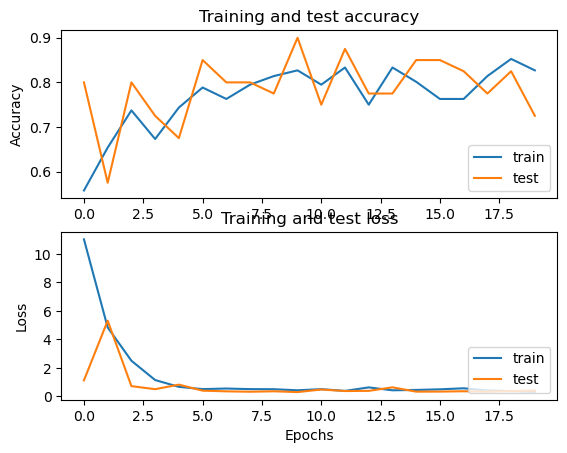

In [16]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()

In [17]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [18]:
results = []

# Loop over negative test images
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])
  
# Loop over positive test images
for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])
  
# Sort results by confidence in descending order
sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 122ms/step
Done inference!


In [19]:
df.head()

,filepath,filename,label,guess,confidence
0,files/images/Pneumothorax/test/positive/000257...,00025787_039.jpg,pos,pos,0.999217
1,files/images/Pneumothorax/test/positive/000206...,00020671_010.jpg,pos,pos,0.986851
2,files/images/Pneumothorax/test/positive/000286...,00028628_008.jpg,pos,pos,0.981854
3,files/images/Pneumothorax/test/positive/000301...,00030162_029.jpg,pos,pos,0.968856
4,files/images/Pneumothorax/test/positive/000276...,00027652_003.jpg,pos,pos,0.915072


1/1 [==============================] - 0s 132ms/step


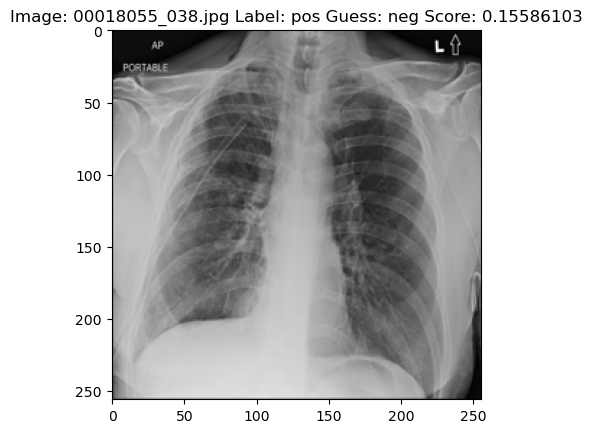

In [20]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [21]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00025787_039.jpg,pos,pos,0.999217
5,00014626_017.jpg,pos,pos,0.914024
10,00011355_011.jpg,pos,pos,0.519471
15,00007471_003.jpg,pos,neg,0.436484
20,00000048_000.jpg,neg,neg,0.234012
25,00000054_007.jpg,neg,neg,0.060337
30,00000050_001.jpg,neg,neg,0.015981
35,00000054_005.jpg,neg,neg,0.002254


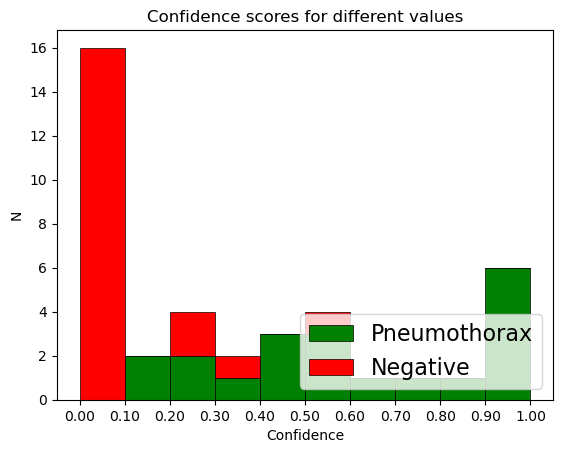

In [22]:
from matplotlib.ticker import FormatStrFormatter
# Select confidence scores for positive and negative labels
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
# Create a histogram
fig, ax = plt.subplots()
n, bins, patches = plt.hist(
    [pos, neg],
    np.arange(0.0, 1.1, 0.1).tolist(),
    edgecolor='black',
    linewidth=0.5,
    density=False,
    histtype='bar',
    stacked=True,
    color=['green', 'red'],
    label=[finding, 'Negative']
)
# Customize the plot
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

Saving the model

In [ ]:
model.save('/home/piyush/Documents/miniproject/files/export/'+finding)